In [12]:
# Download the FER-2013 dataset from kaggle
# !pip install kaggle
!kaggle datasets download jangedoo/utkface-new

Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors




  0%|          | 0.00/331M [00:00<?, ?B/s]
  0%|          | 1.00M/331M [00:00<03:56, 1.46MB/s]
  1%|          | 2.00M/331M [00:01<02:46, 2.07MB/s]
  1%|          | 3.00M/331M [00:01<03:06, 1.84MB/s]
  1%|          | 4.00M/331M [00:02<02:49, 2.03MB/s]
  2%|▏         | 5.00M/331M [00:02<02:35, 2.20MB/s]
  2%|▏         | 6.00M/331M [00:02<02:20, 2.43MB/s]
  2%|▏         | 7.00M/331M [00:03<02:23, 2.36MB/s]
  2%|▏         | 8.00M/331M [00:03<02:38, 2.13MB/s]
  3%|▎         | 9.00M/331M [00:04<02:38, 2.14MB/s]
  3%|▎         | 10.0M/331M [00:05<02:47, 2.01MB/s]
  3%|▎         | 11.0M/331M [00:07<06:25, 871kB/s] 
  4%|▎         | 12.0M/331M [00:10<09:07, 612kB/s]
  4%|▍         | 13.0M/331M [00:13<10:18, 539kB/s]
  4%|▍         | 14.0M/331M [00:14<09:37, 576kB/s]
  5%|▍         | 15.0M/331M [00:15<08:34, 644kB/s]
  5%|▍         | 16.0M/331M [00:17<09:05, 606kB/s]
  5%|▌         | 17.0M/331M [00:19<08:35, 639kB/s]
  5%|▌         | 18.0M/331M [00:19<06:39, 822kB/s]
  6%|▌         | 19.0M/331M

In [1]:
# Extract the zip in a dataset folder
!unzip -q utkface-new.zip -d assets/dataset

In [25]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import visualkeras
from tqdm.notebook import tqdm
from PIL import Image
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import (
    Dense, 
    GlobalAveragePooling2D, 
    Dropout, 
    Conv2D, 
    Flatten, 
    MaxPooling2D, 
    Input, 
    BatchNormalization
)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix

In [22]:
BASE_DIR = '../assets/dataset/UTKFace'

In [ ]:
image_paths, age_labels, gender_labels = [], [], []
for filename in os.listdir(BASE_DIR):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

df = pd.DataFrame({'image': image_paths, 'age': age_labels, 'gender': gender_labels})
gender_dict = {0: 'Male', 1: 'Female'}

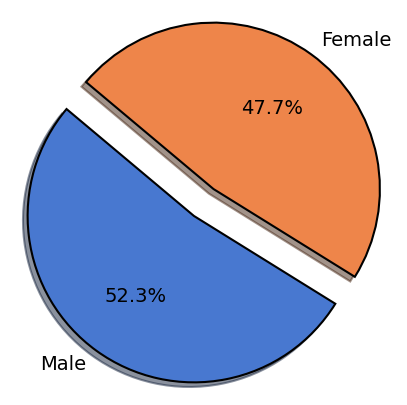

In [5]:
def plot_data(name, data):
    plt.figure(figsize=(5, 5))
    palette_color = sns.color_palette('muted')
    
    # Calculate the number of unique values for explode
    num_unique = data.nunique()
    explode = [0.1] * num_unique 

    target_counts = df.groupby(name)[name].count()

    # Custom labels using gender_dict for better readability
    labels = [gender_dict.get(i, i) for i in target_counts.index] 

    target_counts.plot.pie(
        colors=palette_color,
        explode=explode,
        autopct="%1.1f%%",
        shadow=True,
        startangle=140,
        textprops={'fontsize': 14},
        wedgeprops={'edgecolor': 'black', 'linewidth': 1.5},
        labels=labels,
        ylabel=''
    )

    # Improved title with 'Distribution' for clarity
    # plt.title(f'Distribution of {name}', fontsize=18, weight='bold')  
    plt.axis('equal')
    plt.show()


plot_data('gender', df['gender'])

In [ ]:
sns.distplot(df['age']);
plt.figure(figsize=(5, 4))
sns.histplot(df['age'], kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Density')
plt.show()

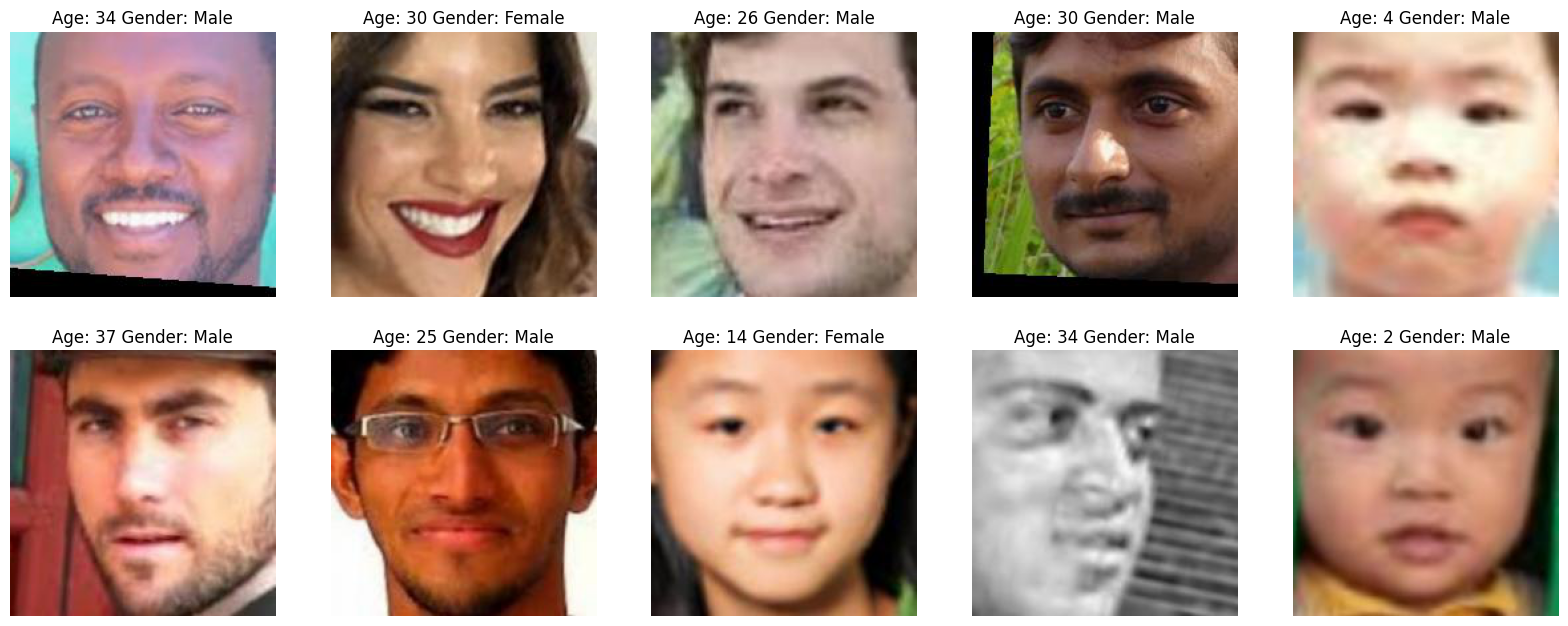

In [7]:
plt.figure(figsize=(20, 20))
files = df.sample(10)

for index, (file, age, gender) in enumerate(files[['image', 'age', 'gender']].values):
    plt.subplot(5, 5, index + 1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')

In [ ]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, color_mode='rgb')
        img = img.resize((128, 128), Image.Resampling.LANCZOS)
        img = np.array(img)
        features.append(img)
    features = np.array(features) / 255.0
    return features

X = extract_features(df['image'])
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [9]:
np.savez('data.npz', X=X, y_gender=y_gender, y_age=y_age)

In [3]:
data = np.load('../assets/dataset/data.npz')

X = data['X']
y_gender = data['y_gender']
y_age = data['y_age']

In [11]:
X_train, X_test, y_train_gender, y_test_gender, y_train_age, y_test_age = train_test_split(
    X, y_gender, y_age, test_size=0.2, random_state=42
)

# `ResNet50`

In [ ]:
base_model = ResNet50(weights=None, include_top=False, input_shape=(128, 128, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)

gender_output = Dense(1, activation='sigmoid', name='gender_out')(x)
age_output = Dense(1, activation='linear', name='age_out')(x)

model = Model(inputs=base_model.input, outputs=[gender_output, age_output])

model.compile(
    loss=['binary_crossentropy', 'mae'], 
    optimizer='adam', 
    metrics={'gender_out': 'accuracy', 'age_out': 'mae'}
    )

# `CNN`

In [ ]:
inputs = Input((128, 128, 3))

conv_1 = Conv2D(filters=256, kernel_size=9, strides=1, padding='valid', activation='relu', name='conv_1') (inputs)
batch_1 = BatchNormalization()(conv_1)
conv_2 = Conv2D(32, 5, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal') (batch_1)
maxp_1 = MaxPooling2D() (conv_2)
dropout_1 = Dropout(0.25) (maxp_1)

flatten = Flatten() (dropout_1)

# fully connected layers
dense_1 = Dense(128, activation = 'relu', kernel_initializer = 'he_normal') (flatten)
dense_2 = Dense(128, activation = 'relu', kernel_initializer = 'he_normal') (flatten)

batch_2 = BatchNormalization() (dense_1)
batch_3 = BatchNormalization() (dense_2)

dropout_2 = Dropout(0.5) (batch_2)
dropout_3 = Dropout(0.5) (batch_3)

output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_2)
output_2 = Dense(1, activation='relu', name='age_out') (dropout_3)


model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy', 'mae'])

In [ ]:
history = model.fit(
    X, [y_gender, y_age], 
    batch_size=32, epochs=30, 
    validation_split=0.2, 
    callbacks=[EarlyStopping(patience=10, restore_best_weights=True)]
    )

# evaluate

In [ ]:
# Save the model (choose one of the options)
model.save('models/custom_ResNet50.h5')  # HDF5 format
model.save('models/custom_ResNet50.keras')  # SavedModel format

# Save the history
np.savez('custom_ResNet50_history.npz', **history.history)

In [26]:
# Load the model
model = tf.keras.models.load_model('../models/age_gender_estimation/custom_CNN/custom_CNN.keras')

c:\Users\froms\anaconda3\envs\si\lib\site-packages\keras\src\saving\saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 20 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


c:\Users\froms\anaconda3\envs\si\lib\site-packages\visualkeras\layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


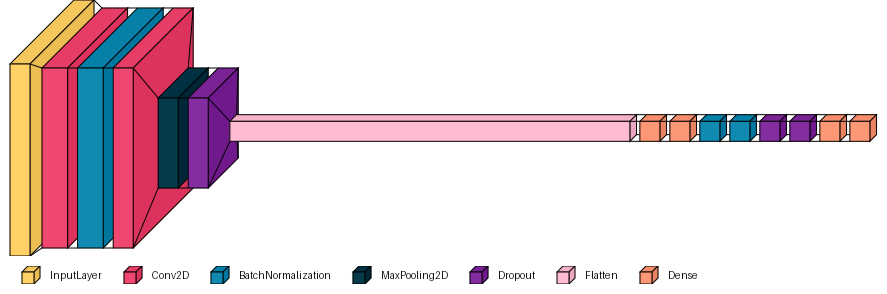

In [52]:
# Visualize the model
visualkeras.layered_view(
    model, 
    legend=True,
    scale_xy=1.5,
    padding=10,
    max_xy=1000,

)

Original Gender: Male Original Age: 10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
Predicted Gender: Male Predicted Age: 12


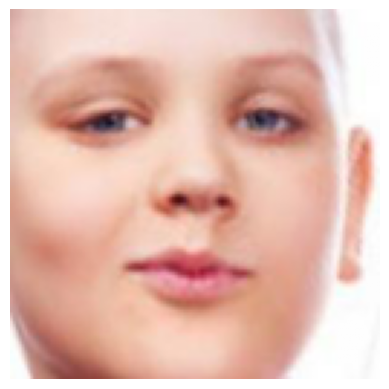

In [12]:
image_index = 58
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])

# preprocess the image
input_image = X[image_index].reshape(128, 128, 3)  # assuming the image is RGB
input_image = np.expand_dims(input_image, axis=0)  # add batch dimension

# predict from model
pred = model.predict(input_image)
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)

plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128, 3))